In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

from fastcore.all import *
!pip install --upgrade duckduckgo_search




ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.


Using the DDG API and defining our function for searching images

In [2]:
from duckduckgo_search import DDGS
ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # return L(ddg_images(term, max_results=max_images)).itemgot('image')
    return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')

urls = search_images('cat loaf', max_images=1)

urls[0]


Searching for 'cat loaf'


'https://www.womansworld.com/wp-content/uploads/2019/07/cat-loaf-position.jpg?resize=1024'

Now we can take a look at our cat :thumbs:

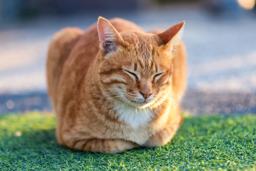

In [ ]:
from fastdownload import download_url
dest = 'cat_loaf.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now, we do the same for bread:

Searching for 'a loaf of bread'


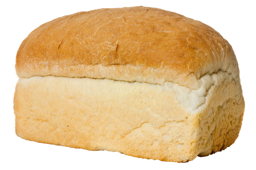

In [6]:
download_url(search_images('a loaf of bread', max_images=1)[0], 'bread_loaf.jpg', show_progress=False)
Image.open('bread_loaf.jpg').to_thumb(256,256)


In [7]:
searches = 'cat loaf', 'bread loaf'
path = Path('bread_or_cat')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} on a table'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} in a pan'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cat loaf photo'


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Searching for 'cat loaf on a table'
Searching for 'cat loaf in a pan'
Searching for 'bread loaf photo'
Searching for 'bread loaf on a table'
Searching for 'bread loaf in a pan'


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

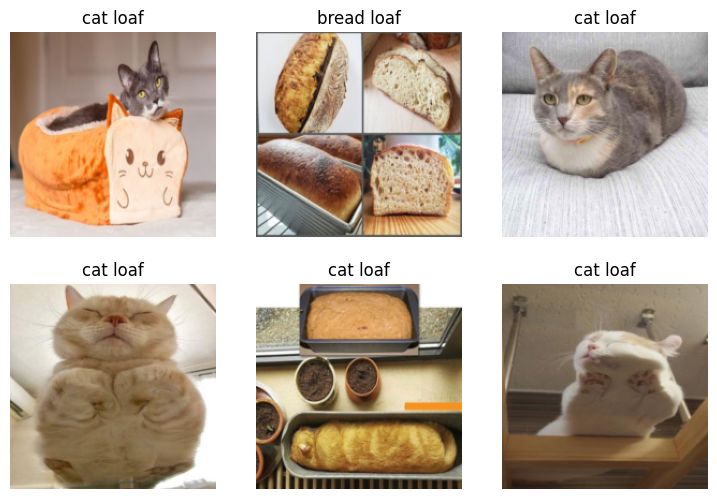

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

`fastai` provides an extremely simple way to fine tune an image model. Here, we use resnet18, which is one of the pre-trained models that fastai contains by default. 

We pass in our `dataloader` object, and call the `fine_tune` function.

**Note**: There is another function that `fastai` provides, called `fit_one_cycle`. These two functions are quite similar, but `fine_tune` contains an extra step where certain model layers are first frozen, and the model is trained without updating the weights(I'll explain further in later sections.)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.056095,1.381201,0.259259,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.297284,0.480456,0.111111,00:18
1,0.201834,0.108897,0.037037,00:18
2,0.139807,0.072797,0.074074,00:18


Now that we have trained our model, let's run it!

In [16]:
is_cat,_,probs = learn.predict(PILImage.create('cat_loaf.jpg'))
print(f"This is a cat: {is_cat}.")
print(f"Probability it's a cat: {probs[1]:.4f}")

This is a cat: cat loaf.
Probability it's a cat: 1.0000
